### Comparison of the coherence metric between the original and surrogate data

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')
import os 

import time
import scipy
import h5py
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import matplotlib.pyplot     as     plt
import seaborn               as     sns
from   tqdm                  import tqdm
from   xfrites.conn.conn_coh import conn_coherence_wav
from   mne.viz import circular_layout, plot_connectivity_circle

from GDa.session             import session_info, session
from GDa.signal.surrogates   import trial_swap_surrogates, phase_rand_surrogates
from GDa.temporal_network    import temporal_network
import GDa.stats.bursting    as     bst

In [2]:
# Create directory to save figures
if not os.path.exists("img/n3.0.4"):
    os.makedirs("img/n3.0.4")

In [3]:
#itr = np.arange(11, dtype=int) * 1000
ks  = 1000
itr = [12000]

#### Load coherence data

In [4]:
#### Original data
net = temporal_network(coh_file=f'super_tensor_k{ks}.nc', monkey='lucy', 
                       session=1, date='150128', trial_type=[1],
                       behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                       relative=True, verbose=True, q=None, keep_weights=False)

In [5]:
# Extract area names
def _extract_roi(roi, sep):
    # Code by Etiene
    x_s, x_t = [], []
    for r in roi:
        _x_s, _x_t = r.split(sep)
        x_s.append(_x_s), x_t.append(_x_t)
    roi_c = np.c_[x_s, x_t]
    idx = np.argsort(np.char.lower(roi_c.astype(str)), axis=1)
    roi_s, roi_t = np.c_[[r[i] for r, i in zip(roi_c, idx)]].T
    roi_st = [f"{s}{sep}{t}" for s, t in zip(roi_s, roi_t)]
    return roi_s, roi_t, roi_st

In [6]:
roi_s, roi_t, _ = _extract_roi(net.super_tensor.roi.values, '-')

#### Statistical testing the distributions (KS-test and t-test)

In [7]:
coh = net.super_tensor.values

In [8]:
from scipy.stats import ks_2samp, ttest_ind

In [9]:
def ks_test(s_idx, verbose=False, n_jobs=1):
    
    from frites.utils import parallel_func
    
    net_surr = temporal_network(coh_file=f'super_tensor_s{s_idx}_k{ks}.nc', monkey='lucy', 
                                session=1, date='150128', trial_type=[1], coh_thr=None,
                                behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                                relative=None, verbose=True, q=None, keep_weights=False)
    coh_surr = net_surr.super_tensor.values
    
    def _for_band(band):
        # Store p-value for KS-test
        ks = np.zeros(coh.shape[0])
        # Store p-value for t-test
        tt = np.zeros(coh.shape[0])
        for i in range( coh.shape[0] ):
            ks[i] = ks_2samp(coh[i,band,...].flatten(),coh_surr[i,band,...].flatten(),  alternative='two-sided')[1]
            tt[i] = ttest_ind(coh[i,band,...].flatten(),coh_surr[i,band,...].flatten(), alternative='two-sided')[1]
        return np.array([ks,tt])
    # define the function to compute in parallel
    parallel, p_fun = parallel_func( _for_band, n_jobs=n_jobs, 
                                     verbose=verbose, total=coh.shape[1]
                                   )
    p_values = parallel(p_fun(band) for band in range(coh.shape[1]))
    return np.asarray(p_values).T

In [10]:
p_values = []
for i in itr:
    p_values += [ks_test(i,True,5)]

  0%|          |  : 0/5 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.7min finished


In [11]:
p_values = np.mean(p_values, axis=0)

In [12]:
# p-values
p = 1/100

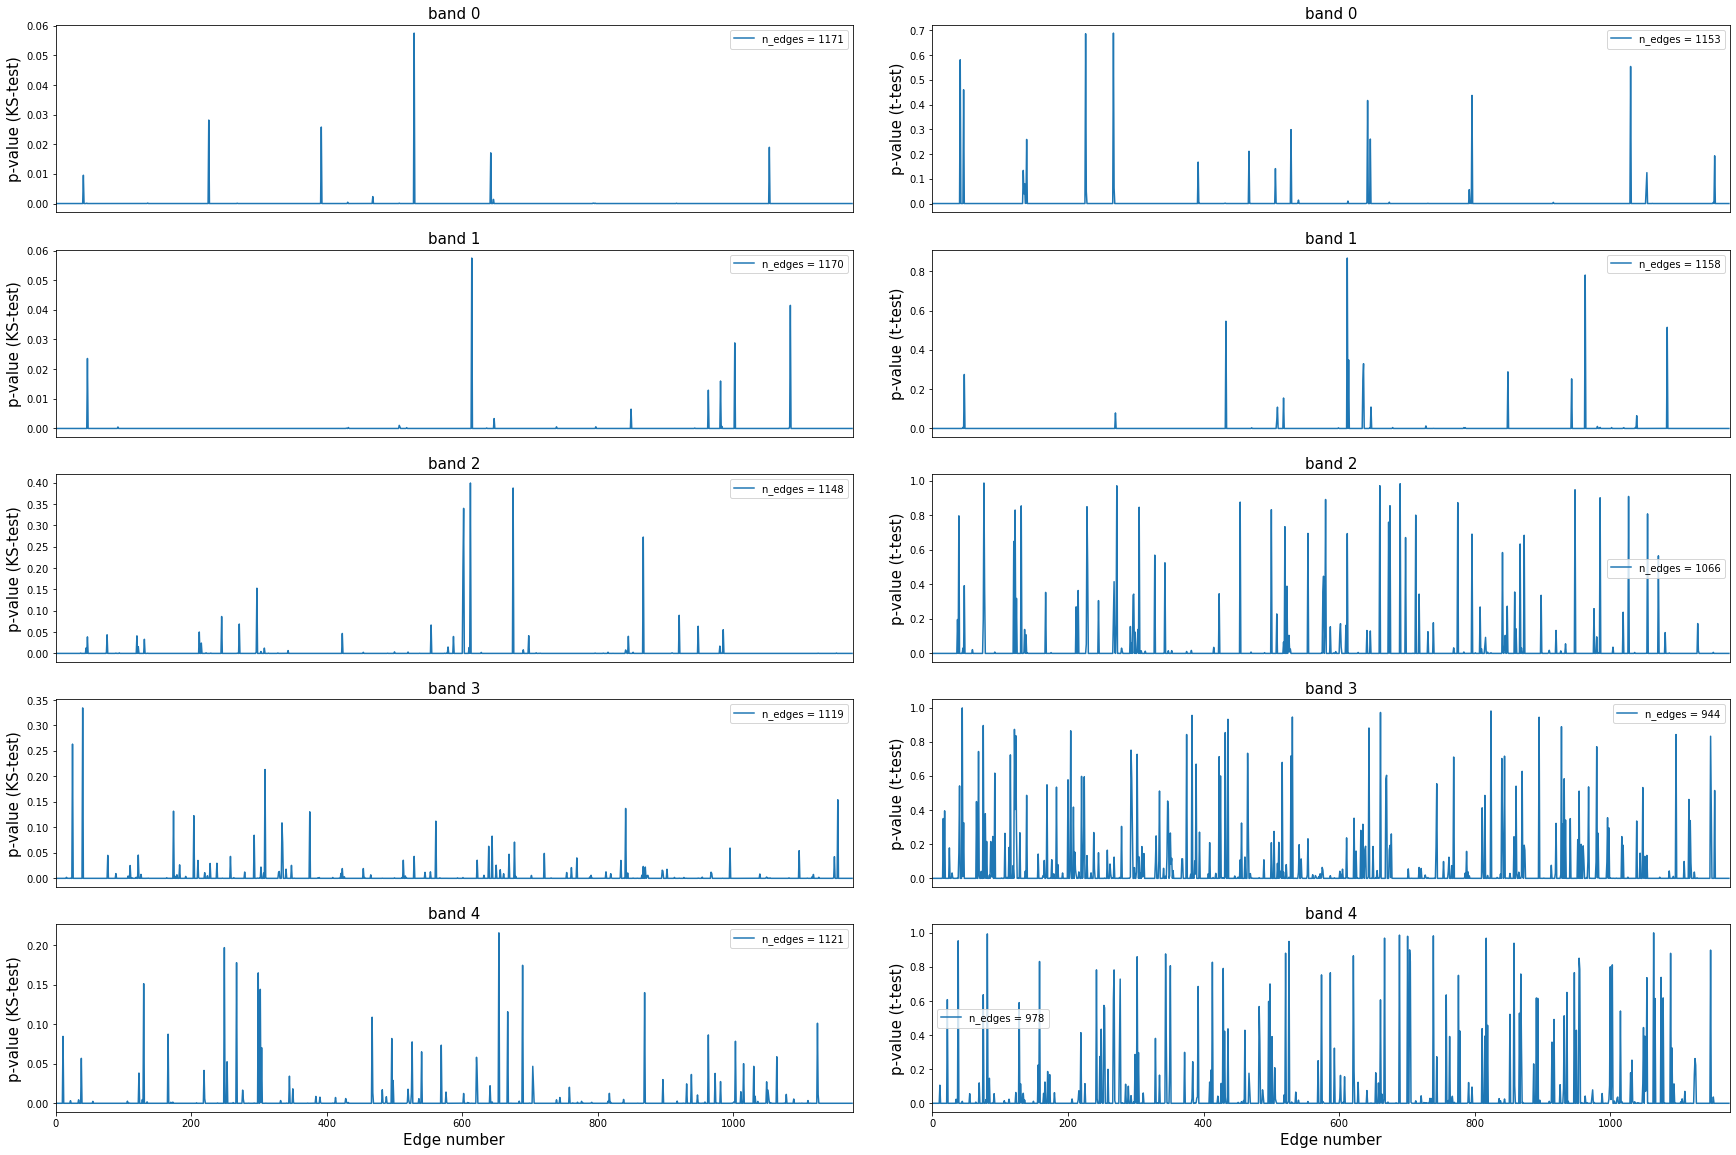

In [13]:
plt.figure(figsize=(30,20))
count = 1
for i in range(net.super_tensor.sizes['freqs']):
    plt.subplot(5,2,count)
    # Plot KS-test p-value
    plt.plot(p_values[:,0,i], label=f'n_edges = {np.sum(p_values[:,0,i]<p)}')
    plt.ylabel('p-value (KS-test)', fontsize=15)
    plt.title(f'band {i}', fontsize=15)
    plt.xlim([0,p_values.shape[0]])
    if i == 4: plt.xlabel('Edge number', fontsize=15)
    else: plt.xticks([])
    plt.legend()
    count += 1
    plt.subplot(5,2,count)
    # Plot t-test p-value
    plt.plot(p_values[:,1,i], label=f'n_edges = {np.sum(p_values[:,1,i]<p)}')
    plt.ylabel('p-value (t-test)', fontsize=15)
    count += 1
    if i == 4: plt.xlabel('Edge number', fontsize=15)
    else: plt.xticks([])
    plt.title(f'band {i}', fontsize=15)
    plt.xlim([0,p_values.shape[0]])
    plt.legend()
plt.subplots_adjust(wspace=0.1)
plt.savefig('img/ks_test.png', dpi=200)

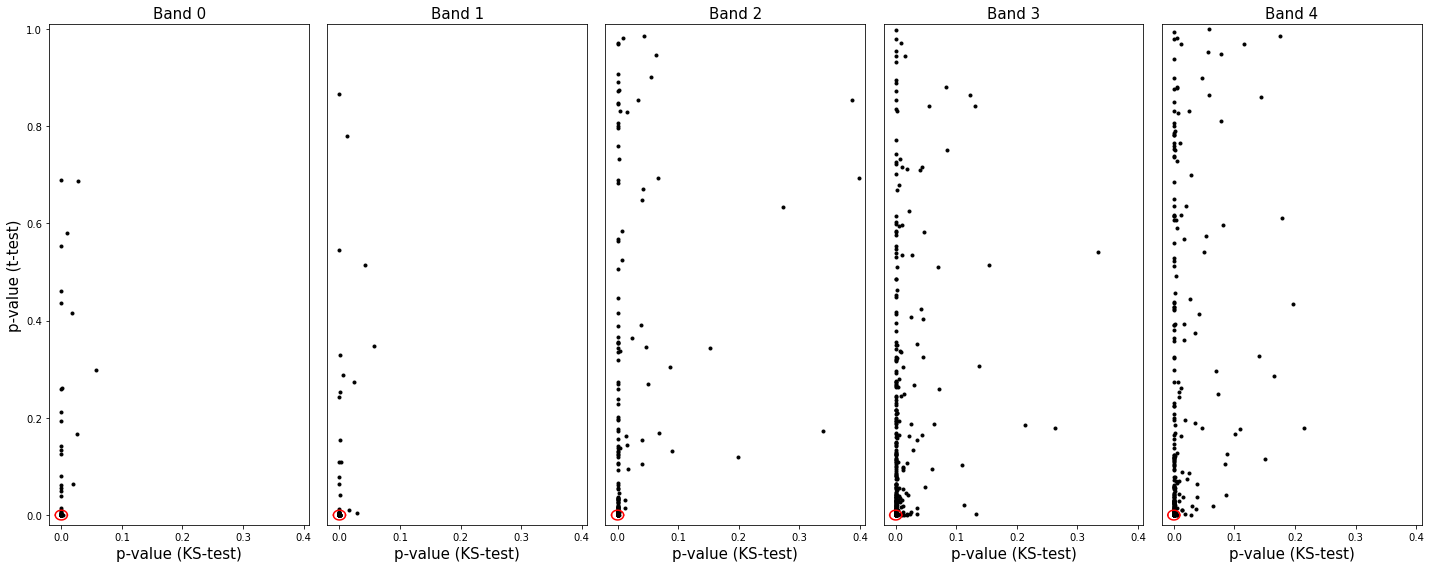

In [14]:
plt.figure(figsize=(20,8))
for i in range(net.super_tensor.sizes['freqs']):
    plt.subplot(1,5,i+1)
    # Create scatter plot 
    plt.scatter(p_values[:,0,i],p_values[:,1,i], marker='.', color='k')
    # Surround the area corresponding to the links with low p-value 
    x = np.linspace(-p,p,100)
    y = np.sqrt(p**2-x**2)
    plt.plot(x,y,'r')
    plt.plot(x,-y,'r')
    if i==0: plt.ylabel('p-value (t-test)', fontsize=15)
    if i>0: plt.yticks([])
    plt.xlabel('p-value (KS-test)', fontsize=15)
    plt.title(f'Band {i}', fontsize=15)
    plt.ylim(-0.02, p_values[:,1,:].max()+0.01)
    plt.xlim(-0.02, p_values[:,0,:].max()+0.01)
plt.tight_layout()

In [15]:
x_s, x_t = net.super_tensor.attrs['sources'], net.super_tensor.attrs['targets']
ks_mat = np.zeros((5,net.super_tensor.attrs['nC'],net.super_tensor.attrs['nC']))
for i in range(net.super_tensor.sizes['freqs']):
    idx         = (p_values[:,0,i]<p)*(p_values[:,1,i]<p)
    x_s_i,x_t_i = x_s[idx], x_t[idx]
    ks_mat[i,x_s_i,x_t_i] = ks_mat[i,x_t_i,x_s_i] = 1

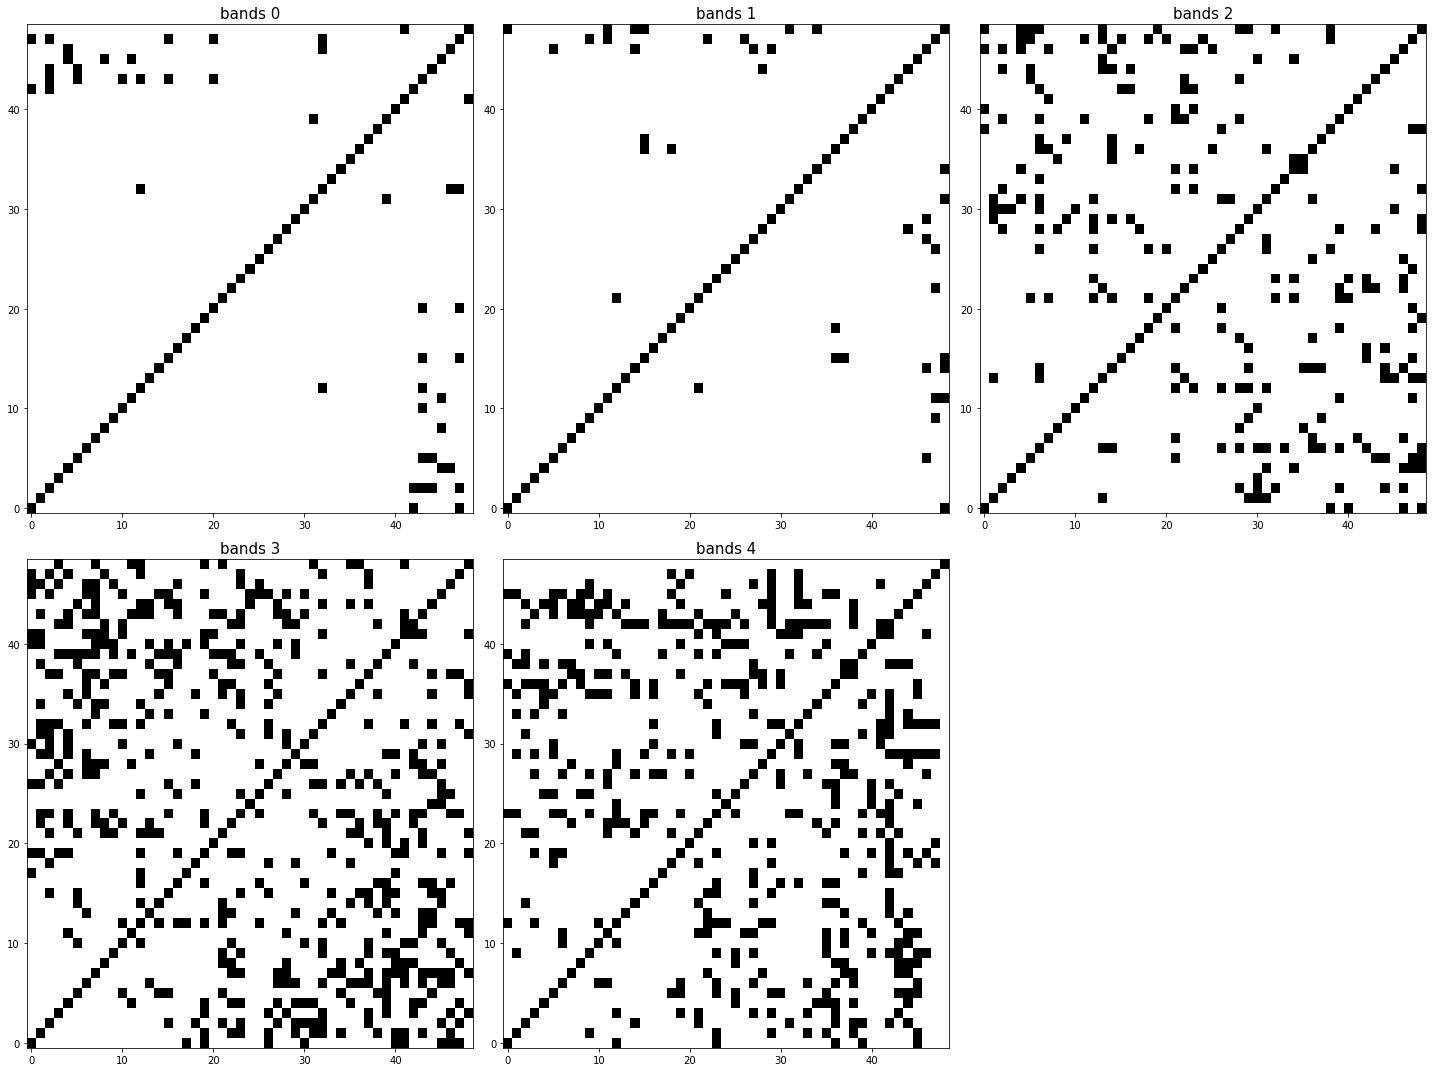

In [16]:
plt.figure(figsize=(20,15))
for i in range(net.super_tensor.sizes['freqs']):
    plt.subplot(2,3,i+1)
    plt.imshow(ks_mat[i], aspect='auto', origin = 'lower', cmap='gray')
    #plt.xticks(range(data.sizes['roi']), data.roi.values, rotation=270)
    #plt.yticks(range(data.sizes['roi']), data.roi.values)
    plt.title(f'bands {i}', fontsize=15)
plt.tight_layout()

#### Checking a few histograms with p<1/100

In [17]:
coh_surr = []
for i in tqdm( itr ):
    net_surr = temporal_network(coh_file=f'super_tensor_s{i}_k{ks}.nc', monkey='lucy', 
                                session=1, date='150128', trial_type=[1], coh_thr=None,
                                behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                                relative=None, verbose=True, q=None, keep_weights=False)
    
    coh_surr.append(net_surr.super_tensor.values)

100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


In [18]:
# Edges with signigicative coherence for all bands
idx = (p_values[:,0,0]<p)*(p_values[:,0,1]<p)*(p_values[:,0,2]<p)*(p_values[:,0,3]<p)*(p_values[:,0,4]<p)
idx = np.logical_and(idx,( (p_values[:,1,0]<p)*(p_values[:,1,1]<p)*(p_values[:,1,2]<p)*(p_values[:,1,3]<p)*(p_values[:,1,4]<p) ))

In [19]:
# Sample four edge indexes
ei  = np.sort( np.random.choice( np.where(idx==True)[0], 4) )

100%|██████████| 5/5 [00:00<00:00,  7.61it/s]


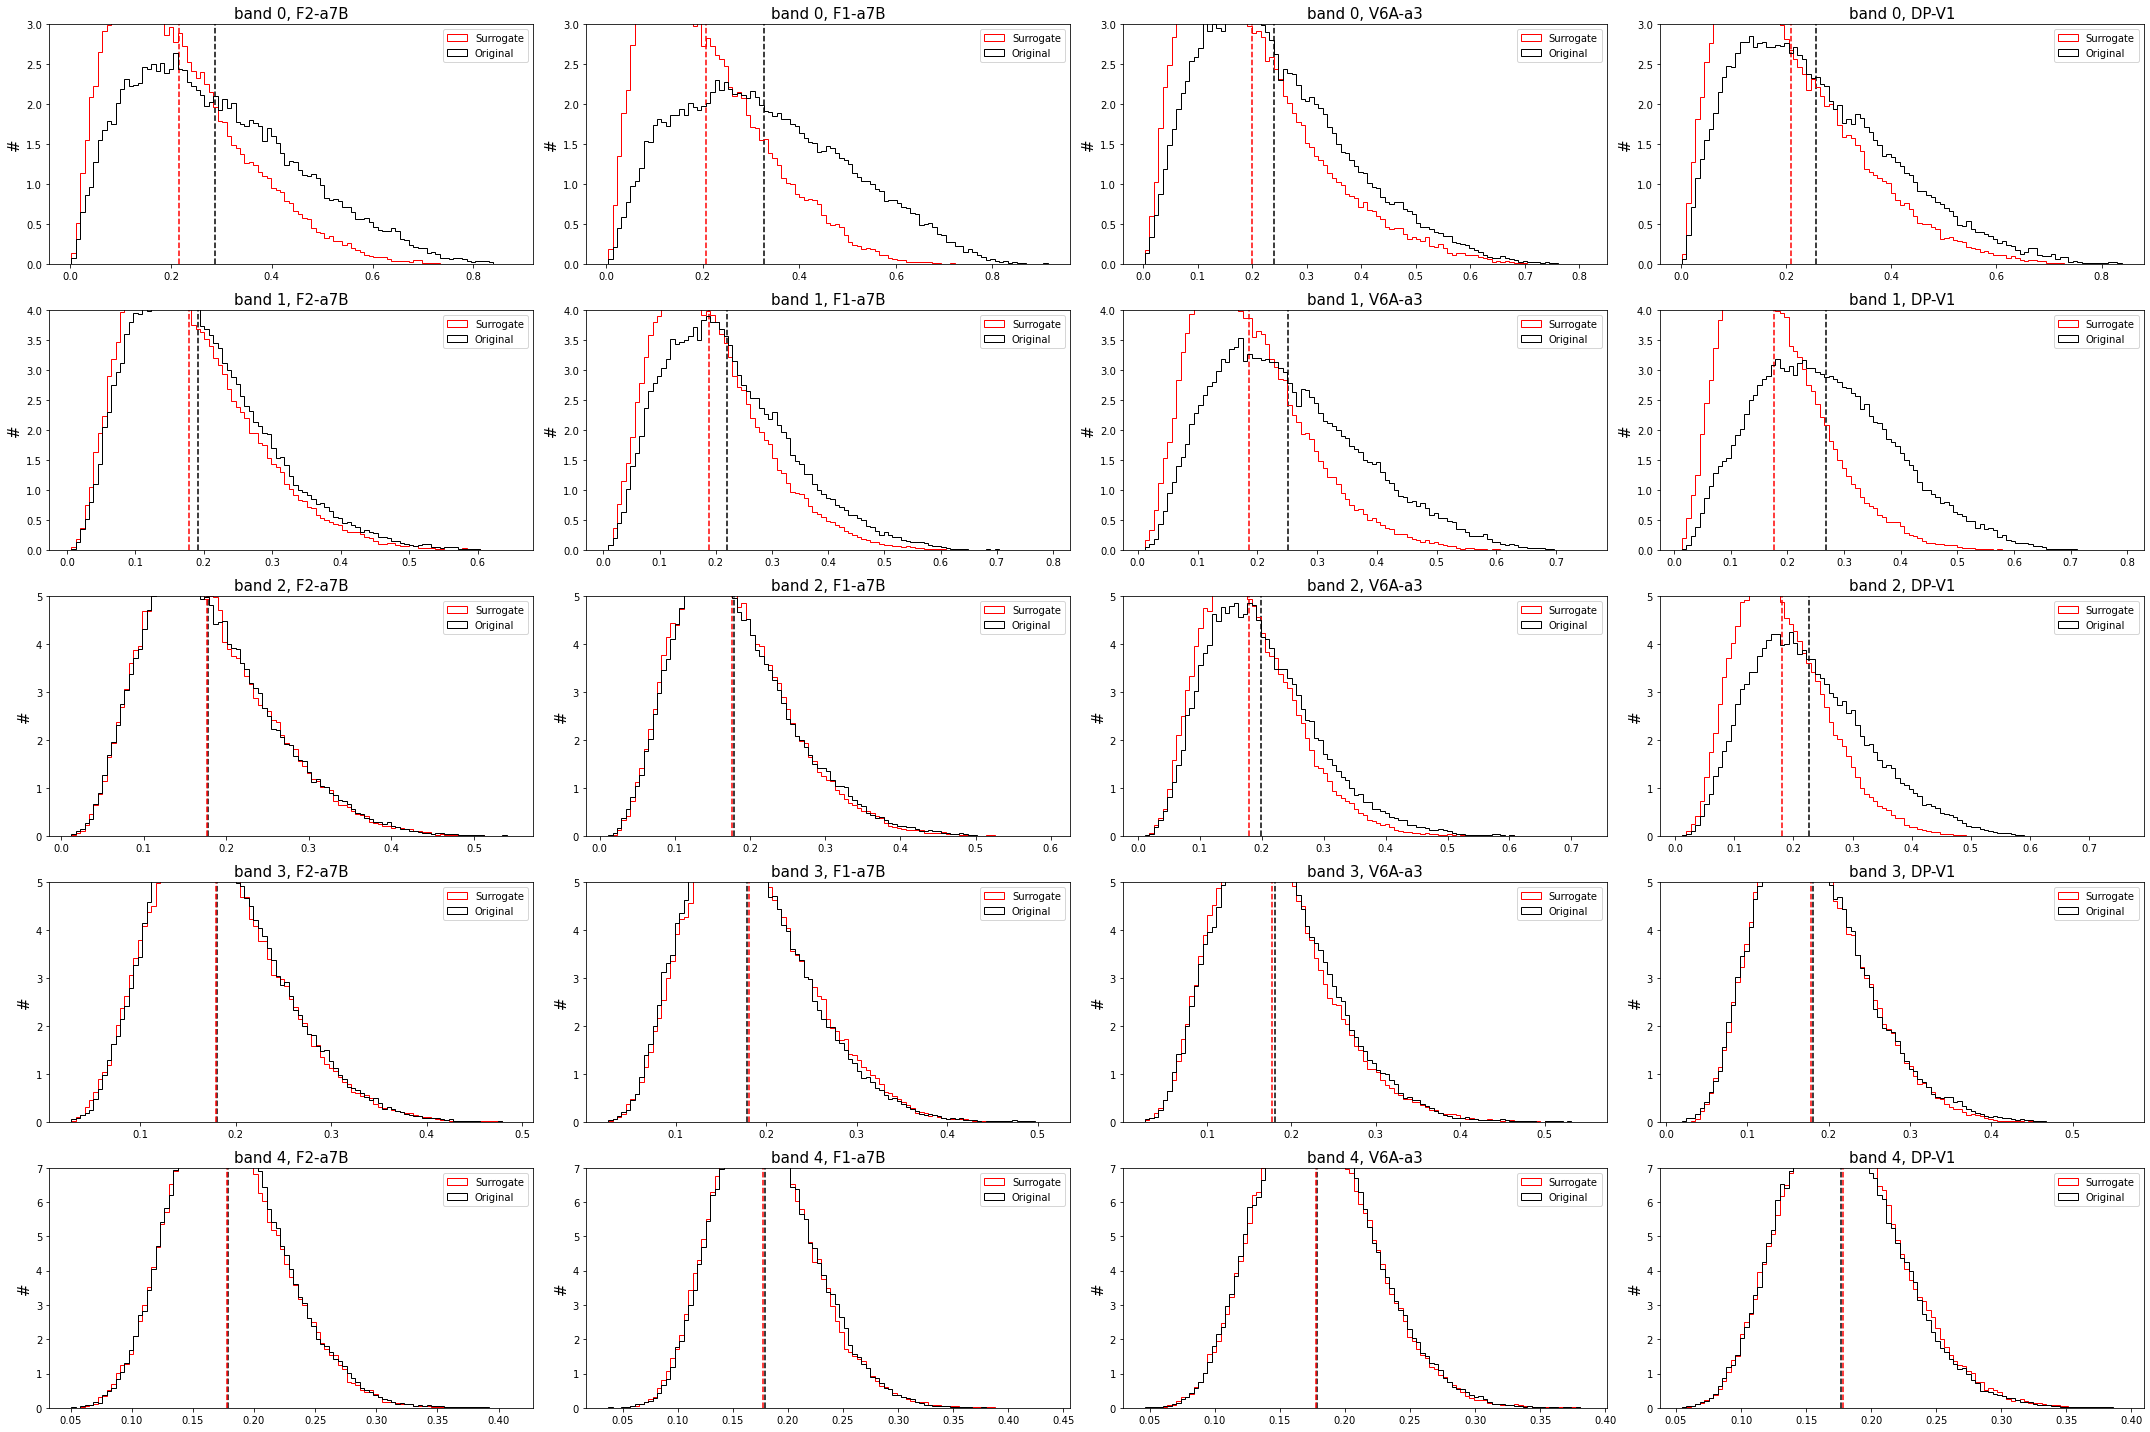

In [20]:
# Saving distributions for trial shuffling surrogates
count = 1
y_max = [3,4,5,5,7]
plt.figure(figsize=(30,20))
for i in tqdm( range(net.super_tensor.sizes['freqs']) ):
    for r in ei:#tqdm( range(coh.sizes['roi']) ):
        bins = np.linspace(coh[r,i,...].min(),coh[r,i,...].max(),100)
        plt.subplot(net.super_tensor.sizes['freqs'],len(ei),count)
        for s in range(len(itr)):
            if s==0: plt.hist(coh_surr[s][r,i,...].flatten(), bins=bins, density=True, histtype='step', fill=False, color='r', label=f'Surrogate');
            else:    plt.hist(coh_surr[s][r,i,...].flatten(), bins=bins, density=True, histtype='step', fill=False, color='r')
        plt.hist( coh[r,i,...].flatten(), bins=bins,  density=True, histtype='step', fill=False, color='k', label='Original', lw=1);
        # Compute mean to plot
        m_orig = coh[r,i,...].mean()
        m_surr = coh_surr[s][r,i,...].mean()
        # Plot mean values as vertical bar
        plt.ylim(0,y_max[i])
        plt.vlines(m_orig, 0, 10, colors='k', linestyles='dashed')
        plt.vlines(m_surr, 0, 10, colors='r', linestyles='dashed')
        plt.title(f'band {i}, {net.super_tensor.roi.values[r]}', fontsize=15)
        plt.ylabel('#', fontsize=15) 
        plt.legend()
        count += 1
plt.tight_layout()

### Plotting number of siginificant links for each pair of regions

In [21]:
unique_rois = np.unique( np.concatenate( (roi_s, roi_t) ) )
mapping     = dict( zip(unique_rois,range(len(unique_rois))) )

#fig = plt.figure(figsize=(12,12))
colors = ['g','r','r','r','#00fbff', 
          'g', 'white', 'g','g','g',
          'b','m','b','b','b','#00fbff', 
          '#00fbff', '#00fbff', 'b', 'b', 'b', 'b']
# Order the nodes according to region
node_order = np.argsort(colors)
colors     = np.sort(colors)
_colorbar  = True

for band in range(5):
    idx = p_values[...,band]<p
    idx = idx[:,0]*idx[:,1]
    


    s,t,_ = _extract_roi(net.super_tensor.roi[idx].values, "-")

    df    = pd.DataFrame( net.super_tensor.roi[idx].values , columns=["links"])

    links  = df["links"].value_counts(normalize=False).index.values
    counts = df["links"].value_counts(normalize=False).values
    s,t,_  = _extract_roi(links, "-")

    df     = pd.DataFrame(np.array([links, s, t, counts]).T, columns=["links", "sources", "targets", "counts"])

    df.replace({'sources': mapping, 'targets': mapping}, inplace=True)

    m      = np.zeros((len(unique_rois),len(unique_rois)))

    c=0
    for i,j in zip(df.sources.values,df.targets.values):
        m[i,j]=m[j,i]= df.counts.values[c]
        c = c + 1
    
    m = m[np.ix_(node_order)]
    
    fig = plt.figure(figsize=(10,10))
    plot_connectivity_circle(m,unique_rois[node_order], colormap="hot_r", facecolor="white", vmin=0, vmax=20,node_colors=colors,
                         textcolor="k", fig=fig, colorbar=_colorbar, colorbar_size=0.4, colorbar_pos=(-1, 0.5), linewidth=3,
                         title=f"Band {band}", fontsize_title=20,fontsize_names=12, subplot=111, show=False);
    plt.savefig(f"img/n3.0.4/sig_links_b{band}_ks{ks}.pdf", transparent=True)
    plt.close()